## **MOWNIT**, Jakub Stępień

### Laboratorium 4 - tablice wielowymiarowe i mnożenie macierzy

**Instalacja potrzebnych komponentów:**

In [100]:
using Plots
using Statistics
using DataFrames
using Polynomials
using Interpolations
using TaylorSeries
using CSV

**Dane do zadania:**

In [20]:
# Małe macierze do wstępnej kompilacji funkcji
Asmall = [[1.0 4.0]; [0.0 1.0]]
Bsmall = Asmall

2×2 Matrix{Float64}:
 1.0  4.0
 0.0  1.0

### **Zadanie 1:**

Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

    dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależyności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. **(1pkt)**. Do analizy danych można użyć wybranego narzędzia (Julia, R)

**Wersja naiwna:**

In [21]:
function naive_multiplication(A, B)
    C = zeros(Float64, size(A, 1), size(B, 2))
    for i=1:size(A, 1)
        for j=1:size(B, 2)
            for k=1:size(A, 2)
                C[i, j] = C[i, j] + A[i, k] * B[k, j]
            end
        end
    end
    C
end

naive_multiplication (generic function with 1 method)

**Wersja poprawiona:**

In [22]:
# poprawiona funkcja korzytająca z powyższego oraz z faktu, że
# można zmieniać kolejność operacji dodawania (a co za tym idzie kolejnosc petli).
function better_multiplication(A, B)
    C = zeros(Float64, size(A, 1), size(B, 2))
    for j=1:size(B, 2)
        for k=1:size(A, 2)
            for i=1:size(A, 1)
                C[i, j] = C[i, j] + A[i, k] * B[k, j]
            end
        end
    end
    C
end

better_multiplication (generic function with 1 method)

**Kompilacja funkcji:**

In [23]:
@elapsed naive_multiplication(Asmall, Bsmall)

0.048091706

In [24]:
@elapsed better_multiplication(Asmall, Bsmall)

0.046164166

**Zebranie danych do DataFrame:**

In [89]:
rep = repeat(100:50:500, inner=10)
library = Array{Float64}(undef, 0)
better = Array{Float64}(undef, 0)
naive = Array{Float64}(undef, 0)

Float64[]

In [35]:
for i in rep
    ARand = rand(i, i)
    BRand = rand(i, i)
    append!(library, @elapsed ARand * BRand)
    append!(better, @elapsed better_multiplication(ARand, BRand))
    append!(naive, @elapsed naive_multiplication(ARand, BRand))
end

times_comparison = DataFrame(rep = rep, library = library, better = better, naive = naive)

,rep,library,better,naive
,Int64,Float64,Float64,Float64
1,100,0.0198408,0.00138046,0.00279008
2,100,0.00464478,0.00875283,0.00254448
3,100,0.00358199,0.00128594,0.00253576
4,100,0.00396639,0.00129635,0.00251291
5,100,0.00394389,0.00128847,0.00253167
6,100,0.00393619,0.00129488,0.00252737
7,100,0.00394415,0.00129145,0.00249756
8,100,3.9304e-5,0.00128709,0.00250764
9,100,3.708e-5,0.00124936,0.002497


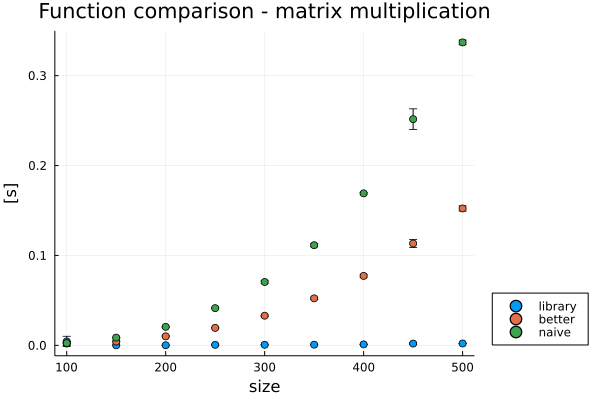

In [36]:
results = combine(
    groupby(times_comparison, :rep),
    "library" => mean,
    "library" => std,
    "better" => mean,
    "better" => std,
    "naive" => mean,
    "naive" => std,
)

plot_1 = scatter(legend=:outerbottomright, xlabel="size", ylabel="[s]", title="Function comparison - matrix multiplication")

plot_1 = scatter!(results.rep, results.library_mean, yerr=results.library_std, label="library")
plot_1 = scatter!(results.rep, results.better_mean, yerr=results.better_std, label="better")
plot_1 = scatter!(results.rep, results.naive_mean, yerr=results.naive_std, label="naive")

### **Zadanie 2:**

Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy(wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). **(1 pkt)**
    
    *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 
Do analizy danych można użyć wybranego narzędzia (Julia, R)

```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <time.h>
#include <sys/times.h>
#include <gsl/gsl_blas.h>

clock_t start_time, end_time;
struct tms timer_start_tms, timer_end_tms;

// Time measurement functions.
void start_timer();
void end_timer();
double calc_time(clock_t start, clock_t end);

// Generate random data for time test.
double** generate_rand_val_square_matrix(int n);
double* generate_rand_val_array(int n);
double* generate_array_with_zeroes(int n);

// Matrix multiplication functions.
double** naive_multiplication(double** A, double** B, int n, int p, int m);
double** better_multiplication(double** A, double** B, int n, int p, int m);

// Free allocated matrix n x m.
void deep_free_matrix(double** A, int n);

int main(int argc, char** argv) {

    FILE* result_file = fopen(argv[1], "w");
    
    // Print header to csv file.
    fprintf(result_file, "rep;gsl;better;naive\n");

    for (int n = 100; n <= 500; n += 50) {
        for (int i = 0; i < 10; i++) {

            // Prepare matrices.
            double** A = generate_rand_val_square_matrix(n);
            double** B = generate_rand_val_square_matrix(n);

            // Prepare arrays.
            double* supp_array_c = generate_rand_val_array(n);
            double* supp_array_d = generate_rand_val_array(n);
            double* supp_array_e = generate_array_with_zeroes(n);

            // Prepare matrix view of given array base.
            gsl_matrix_view C = gsl_matrix_view_array(supp_array_c, n, n);
            gsl_matrix_view D = gsl_matrix_view_array(supp_array_d, n, n);
            gsl_matrix_view E = gsl_matrix_view_array(supp_array_e, n, n);
            
            start_timer();
            gsl_blas_dgemm(CblasNoTrans, CblasNoTrans, 1.0, &C.matrix, &D.matrix, 0.0, &E.matrix);
            end_timer();
            fprintf(result_file, "%d;%lf;", n, calc_time(start_time, end_time));
            start_timer();
            double** F = better_multiplication(A, B, n, n, n);
            end_timer();
            fprintf(result_file, "%lf;", calc_time(start_time, end_time));
            start_timer();
            double** G = naive_multiplication(A, B, n, n, n);
            end_timer();
            fprintf(result_file, "%lf\n", calc_time(start_time, end_time));

            // Free memory.
            free(supp_array_c);
            free(supp_array_d);
            free(supp_array_e);
            deep_free_matrix(A, n);
            deep_free_matrix(B, n);
            deep_free_matrix(F, n);
            deep_free_matrix(G, n);
        }
    }
    fclose(result_file);

    return 0;
}

void start_timer() {
    start_time = clock();
}

void end_timer() {
    end_time = clock();
}

double calc_time(clock_t start, clock_t end) {
    return (double)(end - start)/ CLOCKS_PER_SEC;
}

double** generate_rand_val_square_matrix(int n) {
    srand(time(NULL));
    double** M = (double**) calloc(n, sizeof(double));

    for (int i = 0; i < n; i++) {
        M[i] = (double*) calloc(n, sizeof(double));
    }

    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            M[i][j] = (double) rand() / RAND_MAX;
        }
    }

    return M;
}

double* generate_rand_val_array(int n) {
    srand(time(NULL));
    double* M = (double*) calloc(n * n, sizeof(double));

    for (int i = 0; i < n * n; i++) {
        M[i] = (double) rand() / RAND_MAX;
    }

    return M;
}

double* generate_array_with_zeroes(int n) {
    srand(time(NULL));
    double* M = (double*) calloc(n * n, sizeof(double));

    return M;
}

double** naive_multiplication(double** A, double** B, int n, int p, int m) {
    double** C = (double**) calloc(n, sizeof(double));

    for (int i = 0; i < n; i++) {
        C[i] = (double*) calloc(p, sizeof(double));
    }

    for (int i = 0; i < n; i++) {
        for (int j = 0; j < p; j++) {
            for (int k = 0; k < m; k++) {
                C[i][j] = A[i][k] * B[k][j];
            }
        }
    }

    return C;
}

double** better_multiplication(double** A, double** B, int n, int p, int m) {
    double** C = (double**) calloc(n, sizeof(double));

    for (int i = 0; i < n; i++) {
        C[i] = (double*) calloc(p, sizeof(double));
    }

    for (int i = 0; i < n; i++) {
        for (int k = 0; k < m; k++) {
            for (int j = 0; j < p; j++) {
                C[i][j] = C[i][j] + A[i][k] * B[k][j];
            }
        }
    }

    return C;
}

void deep_free_matrix(double** A, int n) {
    for (int i = 0; i < n; i++) {
        free(A[i]);
    }
    free(A);
}
```

In [113]:
input = "results.csv"
output = CSV.read(input, delim=";", DataFrame)

,rep,gsl,better,naive
,Int64,Float64,Float64,Float64
1,100,0.000713,0.004802,0.003611
2,100,0.00076,0.004671,0.003755
3,100,0.000727,0.004515,0.003512
4,100,0.000735,0.004549,0.003742
5,100,0.0007,0.004427,0.003462
6,100,0.000706,0.00453,0.003453
7,100,0.000687,0.004373,0.003394
8,100,0.000704,0.004355,0.003623
9,100,0.000711,0.004496,0.003571


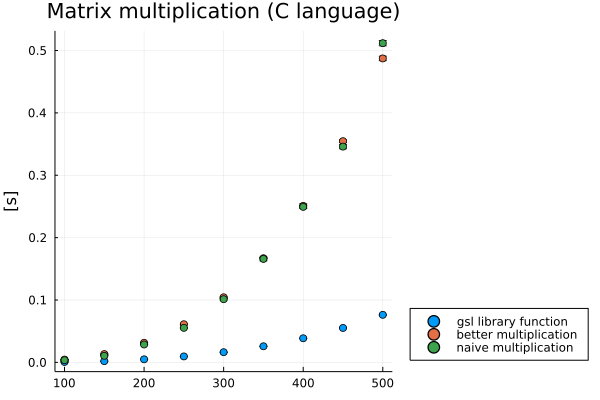

In [118]:
results_2 = combine(
    groupby(output, :rep),
    "gsl" => mean,
    "gsl" => std,
    "better" => mean,
    "better" => std,
    "naive" => mean,
    "naive" => std,
)

plot_2 = scatter(xlable="size", ylabel="[s]", title="Matrix multiplication (C language)", legend=:outerbottomright)

plot_2 = scatter!(results_2.rep, results_2.gsl_mean, yerr=results_2.gsl_std, label="gsl library function")
plot_2 = scatter!(results_2.rep, results_2.better_mean, yerr=results_2.better_std, label="better multiplication")
plot_2 = scatter!(results_2.rep, results_2.naive_mean, yerr=results_2.naive_std, label="naive multiplication")

### **Zadanie 3:**

Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. **(1 pkt)** Do analizy danych można użyć wybranego narzędzia (Julia, R)

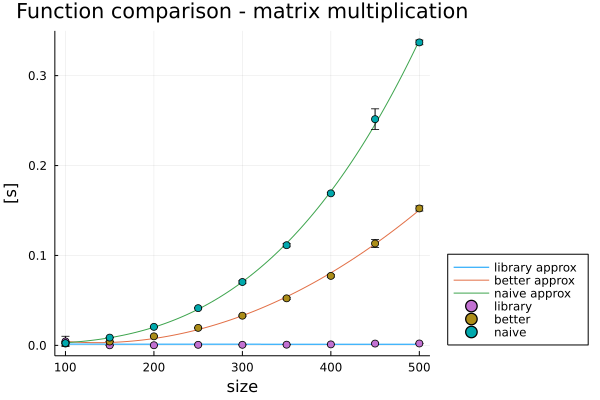

In [98]:
plot_3 = scatter(legend=:outerbottomright, xlabel="size", ylabel="[s]", title="Function comparison - matrix multiplication")

plot_3 = plot!(fit(results.rep, results.library_mean, 1), extrema(results.rep)..., label="library approx")
plot_3 = plot!(fit(results.rep, results.better_mean, 2), extrema(results.rep)..., label="better approx")
plot_3 = plot!(fit(results.rep, results.naive_mean, 3), extrema(results.rep)..., label="naive approx")

plot_3 = scatter!(results.rep, results.library_mean, yerr=results.library_std, label="library")
plot_3 = scatter!(results.rep, results.better_mean, yerr=results.better_std, label="better")
plot_3 = scatter!(results.rep, results.naive_mean, yerr=results.naive_std, label="naive")

### **Zadanie 4:**

Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres. **(1 pkt)**

**Wykres bez wykorzystania  wielomianów Czebyszewa z pakietu Polynomials:**

In [58]:
fun(x) = 1 / (100x^2 + 2);

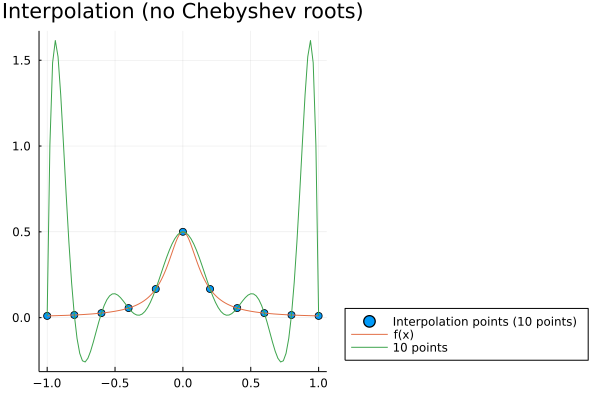

In [61]:
x_1 = -1:0.2:1
y_1 = [fun(x) for x in x_1]

plot_r = scatter(x_1, y_1, label="Interpolation points (10 points)", title="Interpolation (no Chebyshev roots)", legend=:outerbottomright)
plot_r = plot!(fun, label="f(x)")
plot_r = plot!(fit(x_1, y_1), extrema(x_1)..., label="10 points")

**Wykres z wykorzystaniem wielomianów Czebyszewa z pakietu Polynomials:**

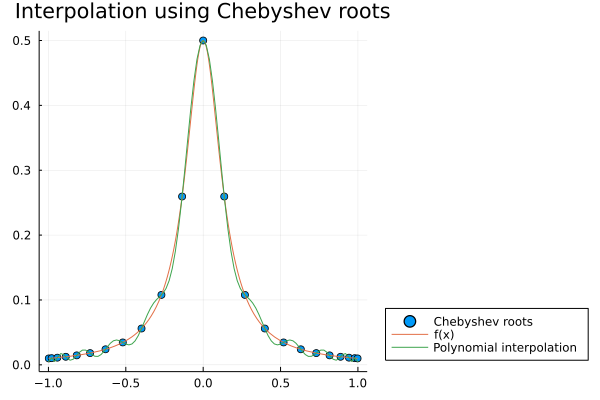

In [63]:
C_roots = zeros(24)
C_roots[24] = 1
roots = Polynomials.roots(ChebyshevT(C_roots))

x_2 = sort(roots)
y_2 = [fun(x) for x in x_2];

plot_r2 = plot(title="Interpolation using Chebyshev roots", legend=:outerbottomright)
plot_r2 = scatter!(x_2, y_2, label="Chebyshev roots")
plot_r2 = plot!(fun, label="f(x)")
plot_r2 = plot!(fit(x_2, y_2), extrema(x_1)..., label="Polynomial interpolation")

### **Zadanie 5:**

Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ **(1 pkt)**

**Funkcja z wykładu:**

In [75]:
F(x) = (7 + (1 + x)^(4 / 3))^(1 / 3)

F (generic function with 1 method)

In [86]:
taylor_values = Taylor1(Float64, 4)
fun_ = F(taylor_values)
p = Polynomial(fun_.coeffs)
pade = Polynomials.PolyCompat.PadeApproximation.Pade(p, 2, 2)

x_3 =  1:1:10
y_3F = [F(x) for x in x_3]
y_3P = [pade(x) for x in x_3];

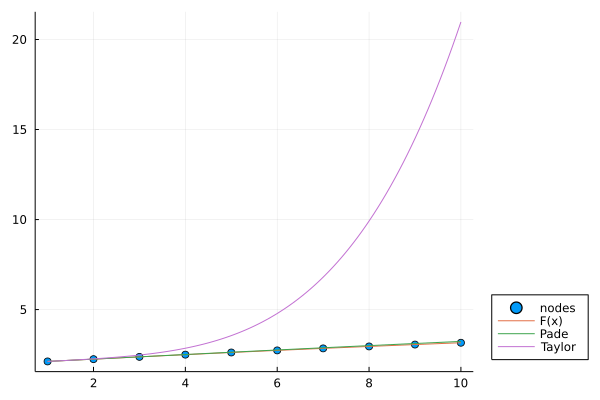

In [88]:
plot_5 = scatter(x_3, y_3F, label="nodes", legend=:outerbottomright)
plot_5 = plot!(F, extrema(x_3)..., label="F(x)")
plot_5 = plot!(x_3, y_3P, label="Pade")
plot_5 = plot!(p, extrema(x_3)..., label="Taylor")